In [14]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dilser(low=0.001, limit=100., dilfactor=2.):
    '''returns a numpy array dilution series from low to limit'''
    #replace this with a generator/iterator someday
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    return np.array(a)

In [3]:
lig_concs = dilser()

In [4]:
def k1solv(var,parm,rtot,ltot):
    
    k1 = parm
    
    (L,R,RL) = var
    
    eq1 = R + RL - rtot
    eq2 = L + RL - ltot
    eq3 = k1 * R * L - RL
    
    return np.array([eq1,eq2,eq3])
    

In [5]:
def lognuniform(low=0, high=1, size=None, base=np.exp(1)):
    return np.power(base, np.random.uniform(low, high, size))

In [6]:
def guessgen(length,lowmag=-3,himag=3,base=10):
    return tuple(lognuniform(low=lowmag,high=himag,base=base) for i in range(length))

In [7]:
guesses = [guessgen(3) for i in range(500)]

In [18]:
res = [[sp.optimize.root(k1solv,i,args=(2.0,0.1,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in guesses]

In [19]:
resc = np.array(res)

In [20]:
L = np.array([stats.mode(resc[:,i,0])[0][0] for i in range(18)])
R = np.array([stats.mode(resc[:,i,1])[0][0] for i in range(18)])
RL = np.array([stats.mode(resc[:,i,2])[0][0] for i in range(18)])

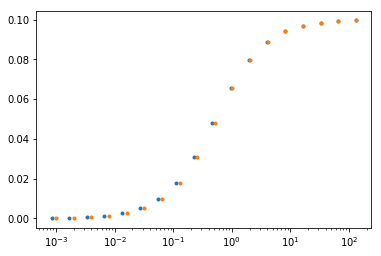

In [21]:
plt.semilogx(L,RL,'.')
plt.semilogx(lig_concs,RL,'.')

In [22]:
def k2solv(var,parm,rtot,ltot):
    
    k1 = parm[0]
    k2 = parm[1]
    
    (L,R,RL,RLL) = var
    
    eq1 = (R + RL + RLL) - rtot
    eq2 = (L + RL + 2*RLL) - ltot
    eq3 = (k1*R*L) - RL
    eq4 = (k2*k1*R*L*L) - RLL
    
    return np.array([eq1,eq2,eq3,eq4])

In [31]:
parmk2 = np.array([4.,1.])

In [60]:
k2guesses = [guessgen(4) for i in range(100)]
resk2 = [[optimize.root(k2solv,i,args=(parmk2,0.1,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in k2guesses]

In [61]:
k2resc = np.array(resk2)

In [62]:
def find_best_root(data,max_lig_index,target_index,lig_max):
    """Returns "most reasonable" root solution from array of solutions
    based on known variables
    
    data -- the array of root solutions for a given binding equation
    max_lig_index -- length of starting ligand concentrations array
    target_index -- index of target solution in root solution tuple
    lig_max -- total receptor concentration used for solution
    """
    holder = []
    for i in range(max_lig_index):
        temp = np.around(data[:,i,target_index],decimals=8)
        holder.append(sp.stats.mode(np.extract(((temp > 0)&(temp < lig_max)),temp))[0][0])
    return np.array(holder)

In [63]:
dL = find_best_root(k2resc,18,0,150)
dR = find_best_root(k2resc,18,1,150)
dRL = find_best_root(k2resc,18,2,150)
dRLL = find_best_root(k2resc,18,3,150)

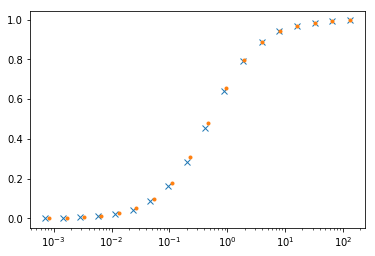

In [64]:
plt.semilogx(dL,((dRL + 2*dRLL)/(dR + dRL + dRLL))/2,'x')
plt.semilogx(L,RL/0.1,'.')

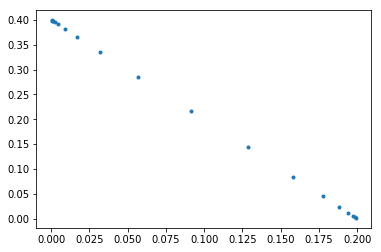

In [50]:
plt.plot((dRL + 2*dRLL),((dRL + 2*dRLL)/dL),'.')

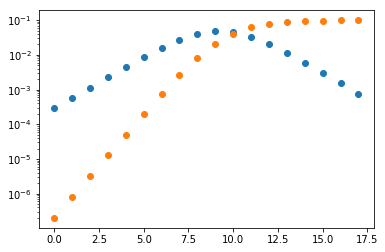

In [51]:
plt.semilogy(dRL,'o')
plt.semilogy(dRLL,'o')

In [52]:
def wymsol(var,parm,rtot,ltot):
    
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    (L, M, MM, ML, MML, MMLL) = var
    
    eq1 = M + 2*MM + ML + 2*MML + 2*MMLL - rtot
    eq2 = L + ML + MML + 2*MMLL - ltot
    eq3 = l20 * M**2 - MM
    eq4 = k11 * L * M - ML
    eq5 = l20 * k21 * M**2 * L - MML
    eq6 = l20 * k21 * k22 * M**2 * L**2 - MMLL
    
    return np.array([eq1,eq2,eq3,eq4,eq5,eq6])

In [85]:
rtotwym = np.array([1e-4,1e-3,1e-2,1e-1,1e0])
parmwym = np.array([2.,4.,1.,500.])
wymguesses = [guessgen(6) for i in range(500)]

In [86]:
reswym = [[[optimize.root(wymsol,i,args=(parmwym,q,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in wymguesses] for q in rtotwym]

In [56]:
wymar = np.array(reswym)

In [59]:
wymar[0].shape

(100, 18, 6)

In [58]:
k2resc.shape

(500, 18, 4)

In [76]:
wymL_0 = find_best_root(wymar[0],18,0,150)
wymM_0 = find_best_root(wymar[0],18,1,150)
wymMM_0 = find_best_root(wymar[0],18,2,150)
wymML_0 = find_best_root(wymar[0],18,3,150)
wymMML_0 = find_best_root(wymar[0],18,4,150)
wymMMLL_0 = find_best_root(wymar[0],18,5,150)

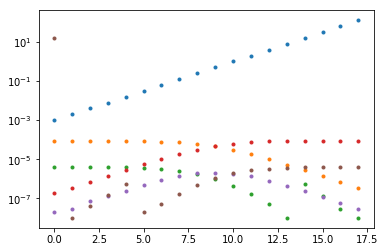

In [84]:
plt.semilogy(wymL_0,'.')
plt.semilogy(wymM_0,'.')
plt.semilogy(wymMM_0,'.')
plt.semilogy(wymML_0,'.')
plt.semilogy(wymMML_0,'.')
plt.semilogy(wymMMLL_0,'.')